In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder

In [125]:
df=pd.read_csv('50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [126]:
# Changing the column names as it contains space in it
# It will not accept in stastsmodel
# For our convinience we will change the column name
df.rename({'R&D Spend':'RDSpend','Marketing Spend':'MarketingSpend'},axis=1,inplace=True)

In [127]:
df.head()

,RDSpend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RDSpend         50 non-null     float64
 1   Administration  50 non-null     float64
 2   MarketingSpend  50 non-null     float64
 3   State           50 non-null     object 
 4   Profit          50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [129]:
# Seems like there is a object type column
# So converting it to int type
LE=LabelEncoder()
scaled_df=df.copy()
scaled_df['State']=LE.fit_transform(scaled_df['State'])

In [130]:
scaled_df.head()


,RDSpend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,2,192261.83
1,162597.70,151377.59,443898.53,0,191792.06
2,153441.51,101145.55,407934.54,1,191050.39
3,144372.41,118671.85,383199.62,2,182901.99
4,142107.34,91391.77,366168.42,1,166187.94


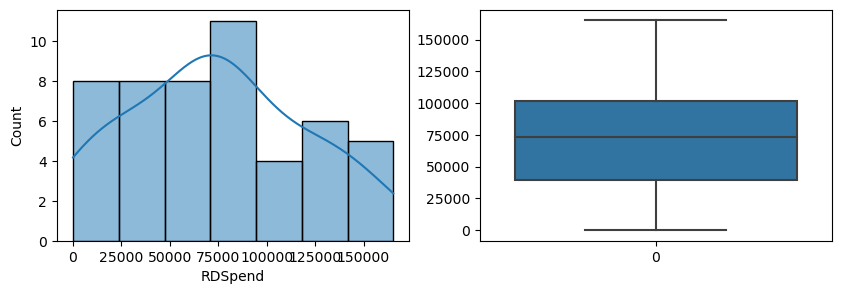

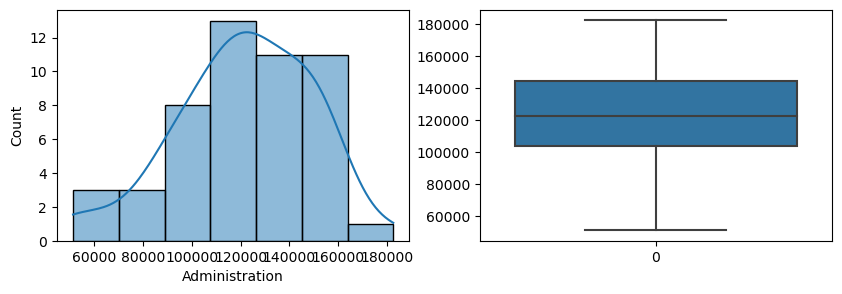

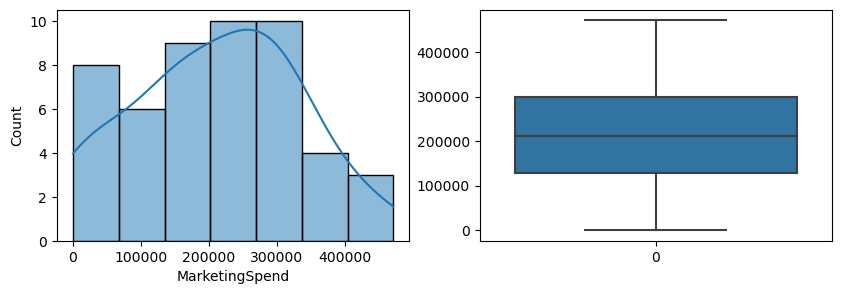

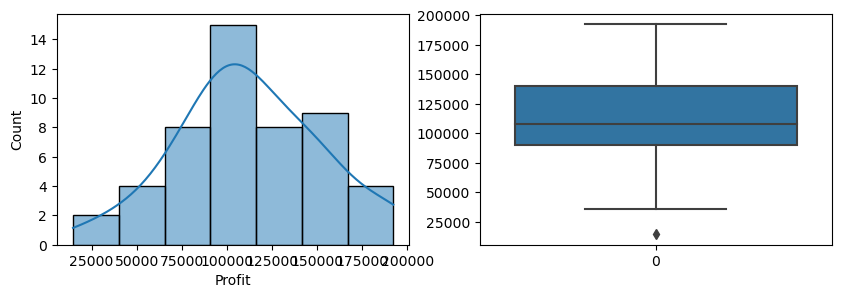

In [131]:
# Ploting Boxplot and histogram
for i in df.columns[[0,1,2,4]]:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    sn.histplot(df[i],kde=True)
    plt.subplot(1,2,2)
    sn.boxplot(df[i])
    plt.show()

<AxesSubplot:>

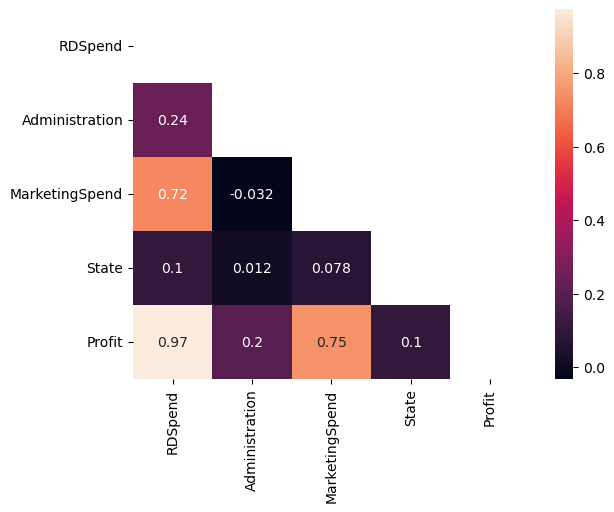

In [132]:
# Seems like there is a outlier present in it
# we will deal with it later
# Now Checking the correlation
sn.heatmap(scaled_df.corr(),annot=True,mask=np.triu(scaled_df.corr()))

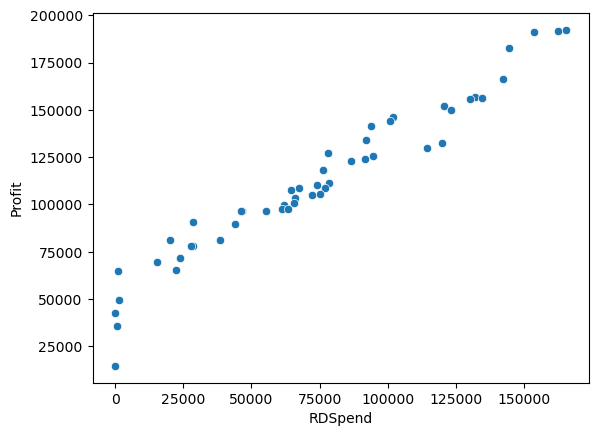

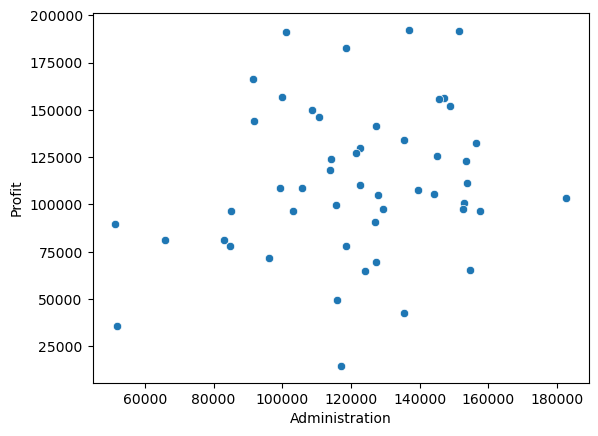

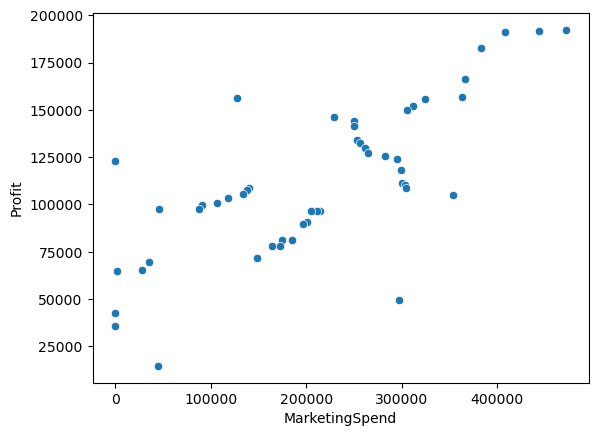

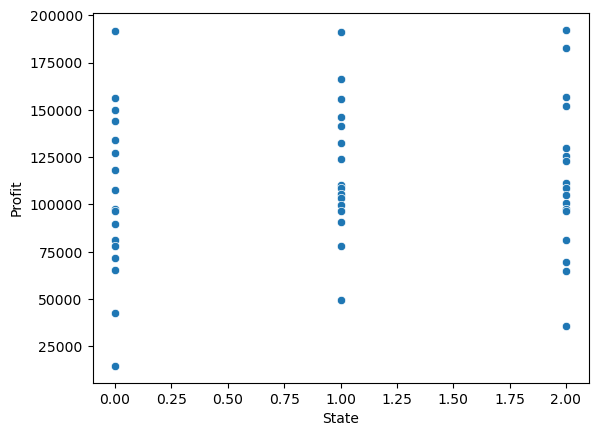

In [133]:
# Plotting scaller plot with target variable
for i in df.columns[:-1]:
    sn.scatterplot(x=scaled_df[i],y=df['Profit'])
    plt.show()
    

In [134]:
# Checking if we need all features
# for that we can remove each feature and check the scores
a=[]
for i in scaled_df.columns[:-1]:
    a.append(smf.ols(f"Profit~{'+'.join([x for x in scaled_df.columns[:-1] if i!=x])}",data=scaled_df).fit().rsquared)

In [135]:
# comparing scores
pd.DataFrame({'Removed Feature':df.columns[:-1],'Scores':a})

,Removed Feature,Scores
0,RDSpend,0.611373
1,Administration,0.950450
2,MarketingSpend,0.947813
3,State,0.950746


In [136]:
# It seems like removing RDSpend column,
# results a singnificant decrease in score
# Which means it may holds all information
#   Checking score of model building with only RDSpend feature
model=smf.ols('Profit~RDSpend',scaled_df).fit()
model.rsquared

0.9465353160804393

In [137]:
# only 1% decrease in score
# which is ok 
# Continuing building model based on a single feature
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     849.8
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           3.50e-32
Time:                        10:17:47   Log-Likelihood:                -527.44
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      48   BIC:                             1063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.903e+04   2537.897     19.320      0.000    4.39e+04    5.41e+04
RDSpend        0.8543      0.029     29.151      0.000       0.795       0.913
==============================================================================
Omnibus:                       13.727   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.536
Skew:                          -0.911   Prob(JB):                     9.44e-05
Kurtosis:                       5.361   Cond. No.                     1.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [138]:
# Improving model

# Checking if outlier present in our data
# Finding cooks distance
c,_=model.get_influence().cooks_distance

<StemContainer object of 3 artists>

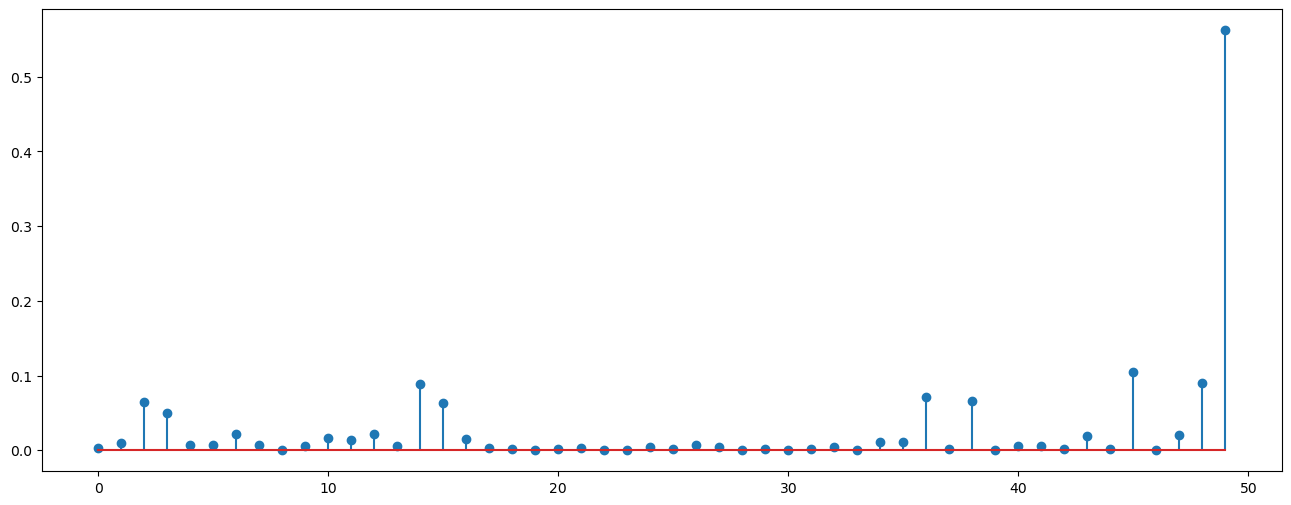

In [139]:
# Plotting cooks distance graph
plt.figure(figsize=(16,6))
plt.stem(c)

In [140]:
#  we can see there is a outlier present in it
np.where(c>(3*(1+1)/len(df)))

(array([49], dtype=int64),)

In [141]:
np.argmax(c),np.max(c)

(49, 0.5620610259264279)

In [142]:
# row index 49 has a outlier
# treating that outlier
# we will first remove it and then check the score
# next we will replace with mean and median 
del_df=scaled_df.iloc[:,[0,-1]].copy()
del_df.drop(49,axis=0,inplace=True)

In [143]:
# Checking score
model_1=smf.ols('Profit~RDSpend',del_df).fit()
b=[model_1.rsquared]                      # Storing scores

In [144]:
# replacing outlier with mean
mean_df=scaled_df.iloc[:,[0,-1]].copy()
mean_df.iloc[49]=np.mean(mean_df,axis=0)
# building model and storing it
model_2=smf.ols('Profit~RDSpend',mean_df).fit()
b.append(model_2.rsquared)

In [145]:
# replacing outlier with median
median_df=scaled_df.iloc[:,[0,-1]].copy()
median_df.iloc[49]=np.mean(mean_df,axis=0)
# building model and storing it
model_3=smf.ols('Profit~RDSpend',median_df).fit()
b.append(model_3.rsquared)

In [146]:
# Comparing scores
pd.DataFrame({'Outlier Treatment':['Removed','Mean','Median'],'Scores':b})

,Outlier Treatment,Scores
0,Removed,0.957340
1,Mean,0.957334
2,Median,0.957340


In [147]:
#  removing outlier and replaced with median gives us same result
# So we will go with removing outlier which is model_1 
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1055.
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           7.56e-34
Time:                        10:17:48   Log-Likelihood:                -508.68
No. Observations:                  49   AIC:                             1021.
Df Residuals:                      47   BIC:                             1025.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.172e+04   2229.914     23.195      0.000    4.72e+04    5.62e+04
RDSpend        0.8278      0.025     32.477      0.000       0.777       0.879
==============================================================================
Omnibus:                        0.070   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.203
Skew:                          -0.080   Prob(JB):                        0.903
Kurtosis:                       2.728   Cond. No.                     1.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [148]:
# Transforming variable and checking if its increasing our scores
# First with log transformation
log_model=smf.ols('Profit~np.log(RDSpend)',del_df).fit()
# log_model.summary()                                       #failed 

c:\Users\kamal\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [149]:
log_y_model=smf.ols('np.log(Profit)~RDSpend',del_df).fit()
log_y_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Profit)   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     389.8
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           2.16e-24
Time:                        10:17:48   Log-Likelihood:                 34.067
No. Observations:                  49   AIC:                            -64.13
Df Residuals:                      47   BIC:                            -60.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9963      0.035    318.718      0.000      10.927      11.066
RDSpend     7.787e-06   3.94e-07     19.744      0.000    6.99e-06    8.58e-06
==============================================================================
Omnibus:                       35.261   Durbin-Watson:                   0.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.223
Skew:                          -1.946   Prob(JB):                     2.85e-22
Kurtosis:                       8.783   Cond. No.                     1.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
# square transformation
sqr_model=smf.ols('Profit~np.square(RDSpend)',del_df).fit()
sqr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     363.5
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           9.36e-24
Time:                        10:17:48   Log-Likelihood:                -532.87
No. Observations:                  49   AIC:                             1070.
Df Residuals:                      47   BIC:                             1074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           7.709e+04   2688.161     28.676      0.000    7.17e+04    8.25e+04
np.square(RDSpend)  4.823e-06   2.53e-07     19.065      0.000    4.31e-06    5.33e-06
==============================================================================
Omnibus:                       12.721   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.715
Skew:                          -1.026   Prob(JB):                      0.00105
Kurtosis:                       4.582   Cond. No.                     1.53e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
# sqrt transformation
sqrt_model=smf.ols('Profit~np.sqrt(RDSpend)',del_df).fit()
sqrt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     390.8
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           2.04e-24
Time:                        10:17:48   Log-Likelihood:                -531.29
No. Observations:                  49   AIC:                             1067.
Df Residuals:                      47   BIC:                             1070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.224e+04   4980.105      4.466      0.000    1.22e+04    3.23e+04
np.sqrt(RDSpend)   358.9697     18.157     19.770      0.000     322.442     395.498
==============================================================================
Omnibus:                        6.105   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.910
Skew:                           0.849   Prob(JB):                       0.0521
Kurtosis:                       2.892   Cond. No.                         757.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
# X + X^2
del_df['squar']=np.square(del_df['RDSpend'])+del_df['RDSpend']
squr_model=smf.ols('Profit~squar',del_df).fit()
squr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     363.5
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           9.36e-24
Time:                        10:17:49   Log-Likelihood:                -532.87
No. Observations:                  49   AIC:                             1070.
Df Residuals:                      47   BIC:                             1074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.709e+04   2688.156     28.676      0.000    7.17e+04    8.25e+04
squar       4.823e-06   2.53e-07     19.065      0.000    4.31e-06    5.33e-06
==============================================================================
Omnibus:                       12.721   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.715
Skew:                          -1.026   Prob(JB):                      0.00105
Kurtosis:                       4.582   Cond. No.                     1.53e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [171]:
#  none of these transformation helps to improve the score

# Checking homoschedasticity
# sclaing will help for better interpretation
SC=StandardScaler()
del_df.drop('squar',axis=1,inplace=True)

In [179]:
del_df['resid']=model_1.resid
del_df['predicted']=model_1.predict()

In [182]:
# scaling resid and predicted
sc_value=SC.fit_transform(del_df.iloc[-2:])

In [ ]:
# plotting scatterplot
# sn.scatterplot(x=SC.fit_transform(del_df['predicted'].values.reshape(-1,1)),y=SC.fit_transform(del_df['resid'].values.reshape(-1,1)))

In [202]:
# while scaling we are getting some error 
# So defining our own Standardise scale
def make_standard(x):
    return (x-np.mean(x))/np.std(x)

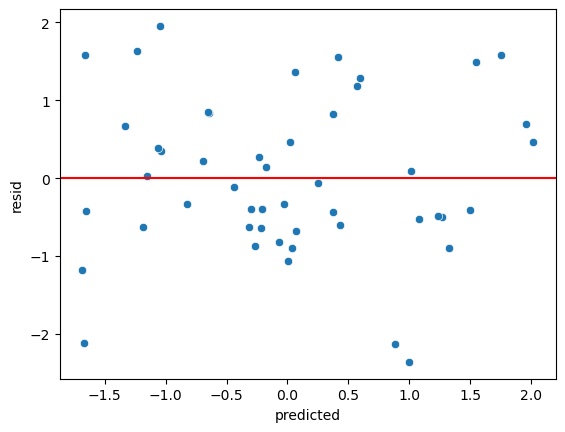

In [208]:
# now plotting scatterplot
sn.scatterplot(x=make_standard(del_df['predicted']),y=make_standard(del_df['resid']))
plt.axhline(y=0,color='r')

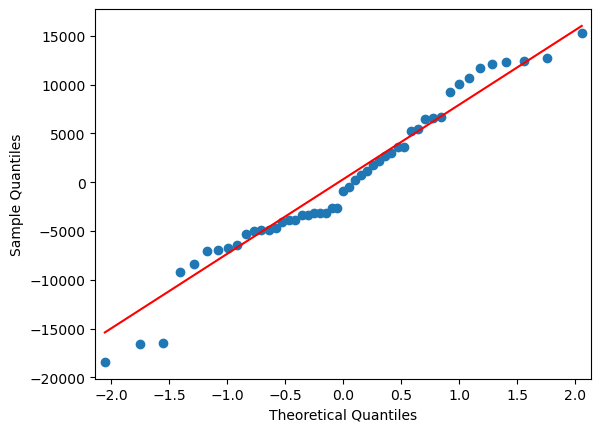

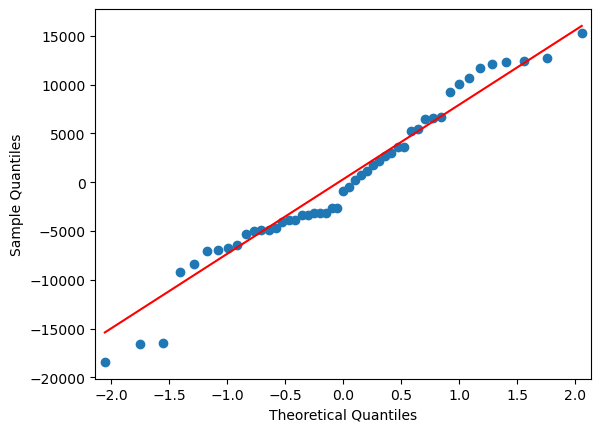

In [215]:
# Checking if error forms normal distribution or not
# we will use QQ plot for this
p=sm.qqplot(del_df['resid'],line='q')

eval_env: 1


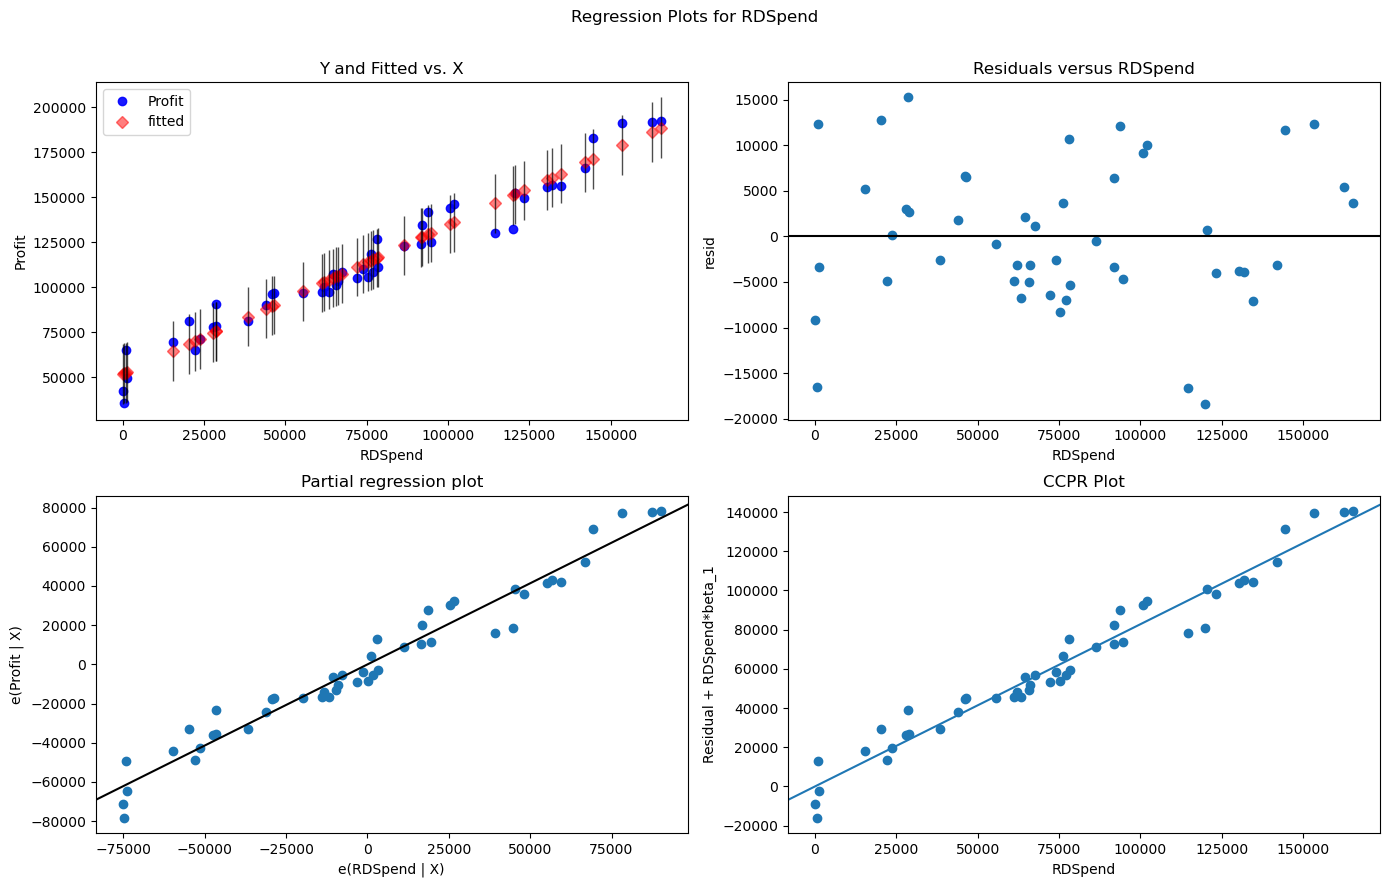

In [220]:
# now checking if error has any relation with feature
pl=sm.graphics.plot_regress_exog(model_1,'RDSpend',fig=plt.figure(figsize=(14,9)))

In [222]:
# Final

# We build a model where we choose 1 feature
# And improve that model
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1055.
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           7.56e-34
Time:                        11:32:30   Log-Likelihood:                -508.68
No. Observations:                  49   AIC:                             1021.
Df Residuals:                      47   BIC:                             1025.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.172e+04   2229.914     23.195      0.000    4.72e+04    5.62e+04
RDSpend        0.8278      0.025     32.477      0.000       0.777       0.879
==============================================================================
Omnibus:                        0.070   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.203
Skew:                          -0.080   Prob(JB):                        0.903
Kurtosis:                       2.728   Cond. No.                     1.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [226]:
# Visualizing our scores
scores=[smf.ols('Profit~RDSpend+Administration+MarketingSpend+State',df).fit().rsquared,model.rsquared,model_1.rsquared]

In [227]:
scores

[0.9507524843355148, 0.9465353160804393, 0.9573395972488337]

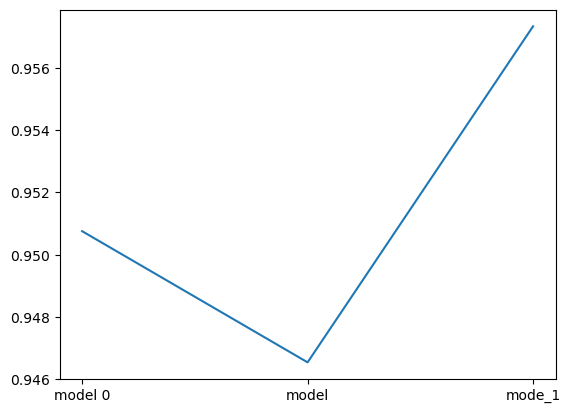

In [246]:
sn.lineplot(y=scores,x=['model 0','model','mode_1'])

: )